# Notebook 3

## Supervised Learning Using simple features

In this notebook, we will train various models on the numeric features that were generated in Notebook 2. 
We will compute the accuracy and the F1 score for each model, perform parameter tuning and compare the different outcomes

In [13]:
%matplotlib inline
import pandas as pd
import numpy as np
import random

#visualization
import seaborn as sns
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

import pickle
import warnings
warnings.filterwarnings('ignore')
import re
from tqdm import tqdm


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

import nltk

In [3]:
df= pd.read_pickle("data/features.pkl")

In [4]:
df.columns

Index(['original_text', 'label', 'preprocessed', 'word_count',
       'avg_word_count', 'syllable_count', 'uncommon', 'difficult_words',
       'stem', 'discourse', 'cohesive_features', 'flesch', 'dale', 'mcalpine',
       'nouns_adjs', 'normalized'],
      dtype='object')

In [5]:
df.shape

(403608, 16)

In [6]:
# noticed that I named a column wrong. It's supposed to be average word length not count
df.rename({'avg_word_count': 'avg_word_length'}, axis=1, inplace=True)

In [7]:
#let's scale the numerical values
cols = ['word_count','avg_word_length', 'syllable_count', 'uncommon', 'difficult_words',\
                  'discourse', 'cohesive_features', 'flesch', 'dale', 'mcalpine','nouns_adjs','label']

In [8]:
df=df[cols]

In [9]:
df.head()

,word_count,avg_word_length,syllable_count,uncommon,difficult_words,discourse,cohesive_features,flesch,dale,mcalpine,nouns_adjs,label
0,35,4.485714,1.371429,14,7,4,2,52.87,11.24,48.0,0.228571,1
1,19,6.000000,1.789474,14,8,2,1,35.27,14.55,23.0,0.315789,1
2,40,4.725000,1.400000,15,9,7,3,47.80,11.15,57.0,0.175000,1
3,32,6.281250,1.781250,22,14,0,1,22.08,14.60,38.0,0.593750,1
4,20,4.650000,1.350000,7,4,0,2,68.10,8.58,29.0,0.400000,1


# Filter Method for Feature Selection

In this method, we only take the subset of the relevant features.The filtering here is done using correlation matrix and it is most commonly done using Pearson correlation.

The correlation coefficient has values between -1 to 1
— A value closer to 0 implies weaker correlation (exact 0 implying no correlation)
— A value closer to 1 implies stronger positive correlation
— A value closer to -1 implies stronger negative correlation

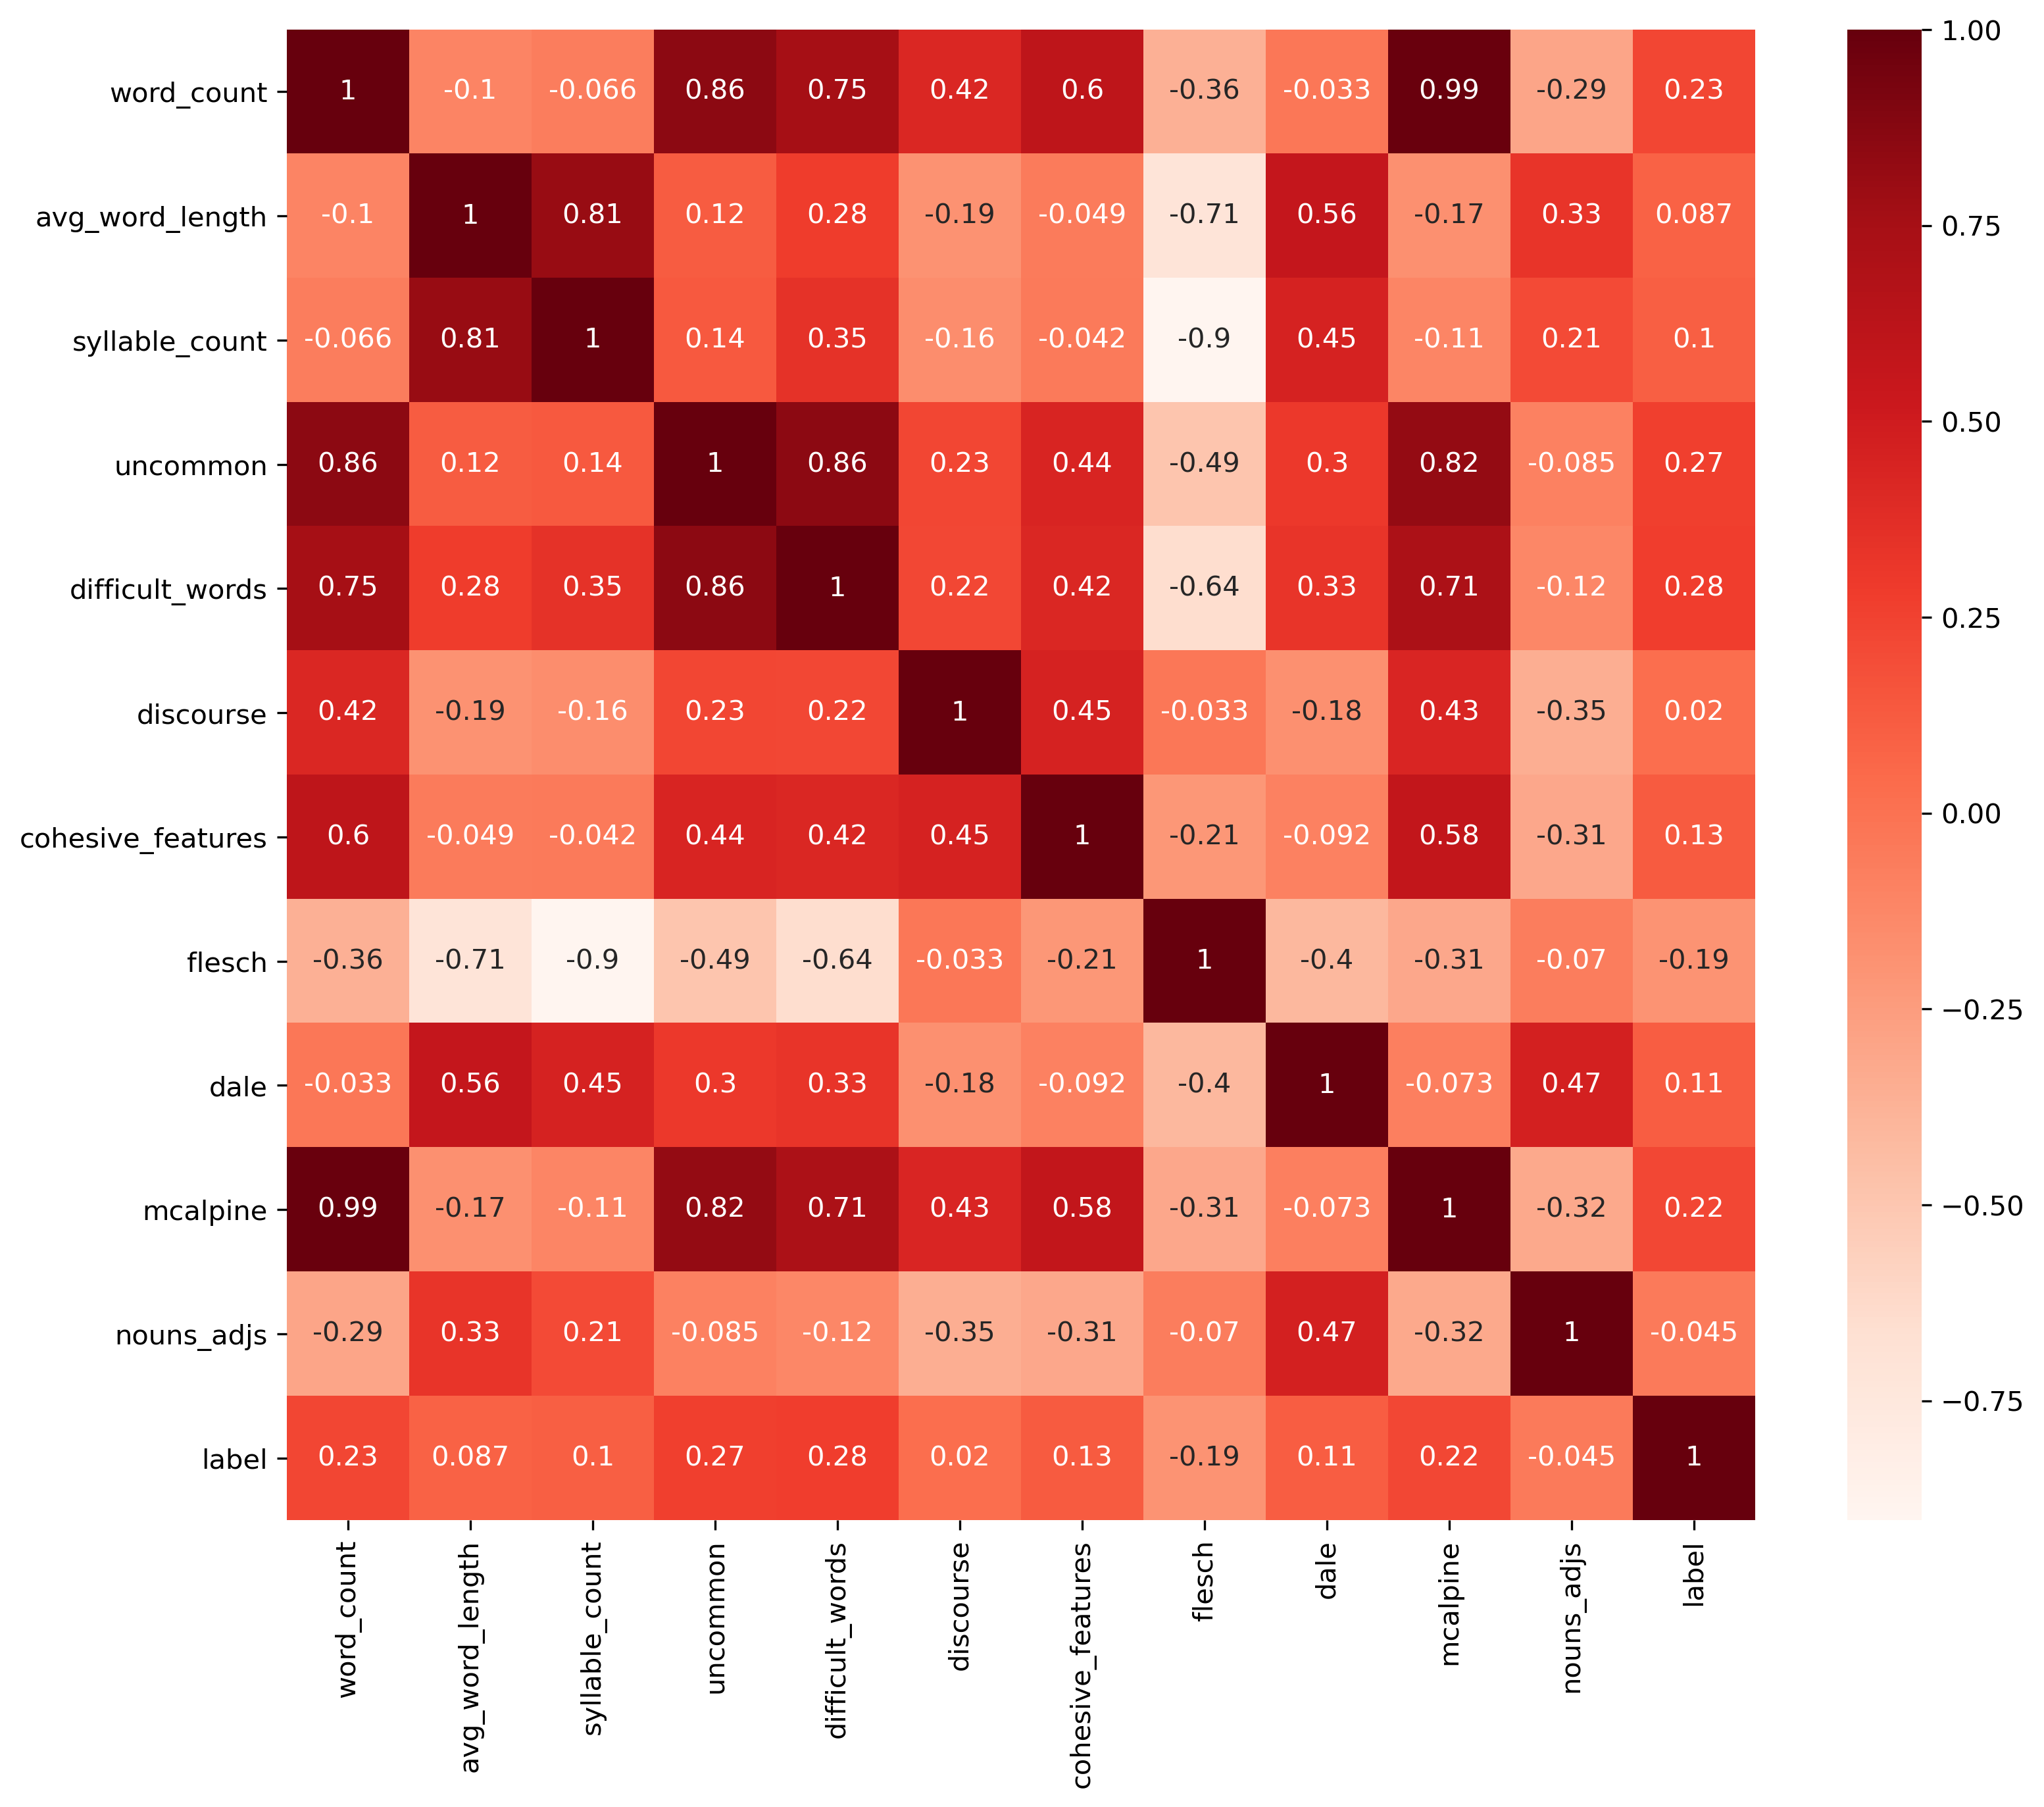

<Figure size 1800x1200 with 0 Axes>

In [15]:
# Pearson correlation heatmap (correlation of independent variables with the output variable label)
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()
plt.savefig('figures/books_read.png')

In [23]:
#Correlation with output variable
cor_target = abs(cor["label"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.2]

relevant_features.to_frame()

,label
word_count,0.230749
uncommon,0.265807
difficult_words,0.275162
mcalpine,0.220585
label,1.000000


# Splitting the data

We have a large enough dataset that we can effectively split it into train, development, and test sets, using the standard ratio of 80%, 10%, 10% for each, respectively. We'll use `split` from `numpy` to split the data into train, dev, and test separately. We'll call these `train_df`, `dev_df`, and `test_df`.  Note that `split` does not shuffle, so we'll use `DataFrame.sample()` and randomly resample our entire dataset to get a random shuffle before the split.

In [24]:
#split the data into training,dev and testing
train_df,dev_df,test_df=np.split(df.sample(frac=1,random_state=42), 
                                 [int(.8*len(df)), 
                                  int(.9*len(df))])

In [25]:
print("There are {} instances in the train dataset".format(train_df.shape[0]))
print("There are {} instances in the dev dataset".format(dev_df.shape[0]))
print("There are {} instances in the test dataset".format(test_df.shape[0]))

There are 322886 instances in the train dataset
There are 40361 instances in the dev dataset
There are 40361 instances in the test dataset


## Scaling the features

Because our features are on very different scales, we will need to scale them. MinMaxScaler(feature_range = (0, 1)) will transform each value in the column proportionally within the range [0,1]. This is usually a good first scaler choice to transform a feature, as it will preserve the shape of the dataset (no distortion).

StandardScaler() will transform each value in the column to range about the mean 0 and standard deviation 1, ie, each value will be normalised by subtracting the mean and dividing by standard deviation.StandardScaler is ideal in scenarios where we know the data distribution is normal.

In [26]:
# training data
X_train = train_df.loc[:, train_df.columns != 'label'].to_numpy()
y_train = train_df['label']

#dev data
X_dev= dev_df.loc[:, dev_df.columns != 'label'].to_numpy()
y_dev = dev_df['label']

# test data
X_test=test_df.loc[:, test_df.columns != 'label'].to_numpy()
y_test = test_df['label']

 `MinMaxScaler(feature_range = (0, 1))` will transform each value in the column proportionally within the range [0,1].

In [27]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_dev_scaled = scaler.transform(X_dev)
X_test_scaled = scaler.transform(X_test)

In [28]:
X_train_scaled

array([[0.24657534, 0.22307692, 0.0625    , ..., 0.37567171, 0.23853211,
        0.2       ],
       [0.16438356, 0.3021978 , 0.16071429, ..., 0.48216903, 0.13761468,
        0.35714286],
       [0.53424658, 0.32082552, 0.13414634, ..., 0.57303371, 0.48623853,
        0.29268293],
       ...,
       [0.12328767, 0.26573427, 0.04545455, ..., 0.47972643, 0.11009174,
        0.27272727],
       [0.16438356, 0.34615385, 0.16071429, ..., 0.5925745 , 0.1559633 ,
        0.35714286],
       [0.20547945, 0.31221719, 0.05882353, ..., 0.57694187, 0.17431193,
        0.29411765]])

## Logistic Regression

In [36]:
#For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones;
clf= LogisticRegression(solver="sag",random_state=42)
clf.fit(X_train_scaled,np.array(y_train))

LogisticRegression(random_state=42, solver='sag')

In [19]:
preds=clf.predict(X_test_scaled)

In [20]:
f1 = f1_score(y_test,preds)

In [21]:
print(f1)

0.6215153412648716


In [24]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test,preds)

print(accuracy)

0.6256039245806595


# Feature importance using recursive feature elimination (RFE)

RFE is a feature selection method that fits a model and removes the weakest feature (or features) until the specified number of features is reached. To get a full ranking of features, we just set the parameter n_features_to_select = 1.Once the model is created, we can conduct feature importance and plot it on a graph to interpret the results easily.

In [40]:
from sklearn.feature_selection import RFE
selector= RFE(clf,n_features_to_select=1)
selector.fit(X_train,y_train)

RFE(estimator=LogisticRegression(random_state=42, solver='sag'),
    n_features_to_select=1)

In [88]:
order= selector.ranking_
feature_rank =[]
dfcoll= df.loc[:,df.columns!='label']

for i in order:
    feature_rank.append(dfcoll.columns[i-1])
    
print(feature_rank)

['mcalpine', 'discourse', 'uncommon', 'difficult_words', 'word_count', 'syllable_count', 'cohesive_features', 'nouns_adjs', 'flesch', 'dale', 'avg_word_length']


## Cross Validation

In [22]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(clf, X_train_scaled, y_train)

print('Cross-validation scores (5-fold):', cv_scores)
print('Mean cross-validation score (5-fold): {:.3f}'
     .format(np.mean(cv_scores)))

Cross-validation scores (5-fold): [0.62691629 0.62263654 0.62234232 0.62578008 0.62545488]
Mean cross-validation score (5-fold): 0.625


## ROC curve

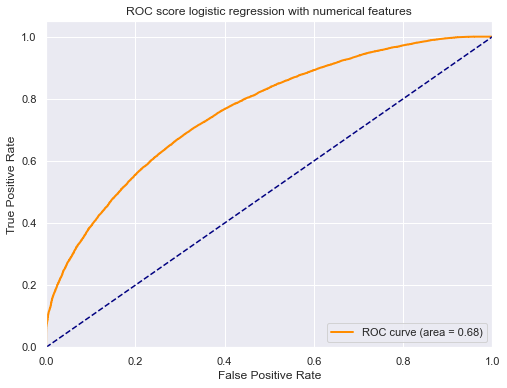

In [31]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()


y_score=clf.predict_proba(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1], pos_label=1)
area = auc(fpr, tpr)

plt.figure(figsize=(8,6))
lw = 2
plt.plot(rf_fpr, rf_tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC score logistic regression with numerical features')
plt.legend(loc="lower right")
plt.savefig('figures/ROC_cl_simplefeatures.jpg')

# Random Forest

Random forest will need not features to be scaled. However, we need to be careful about the depth of the tree. Too deep of a tree will cause overfitting, too shallow will cause underfitting

In [89]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(bootstrap= True,
 max_depth=70,
 max_features='auto',
 min_samples_leaf=4,
 min_samples_split=10,
 n_estimators=800)

rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

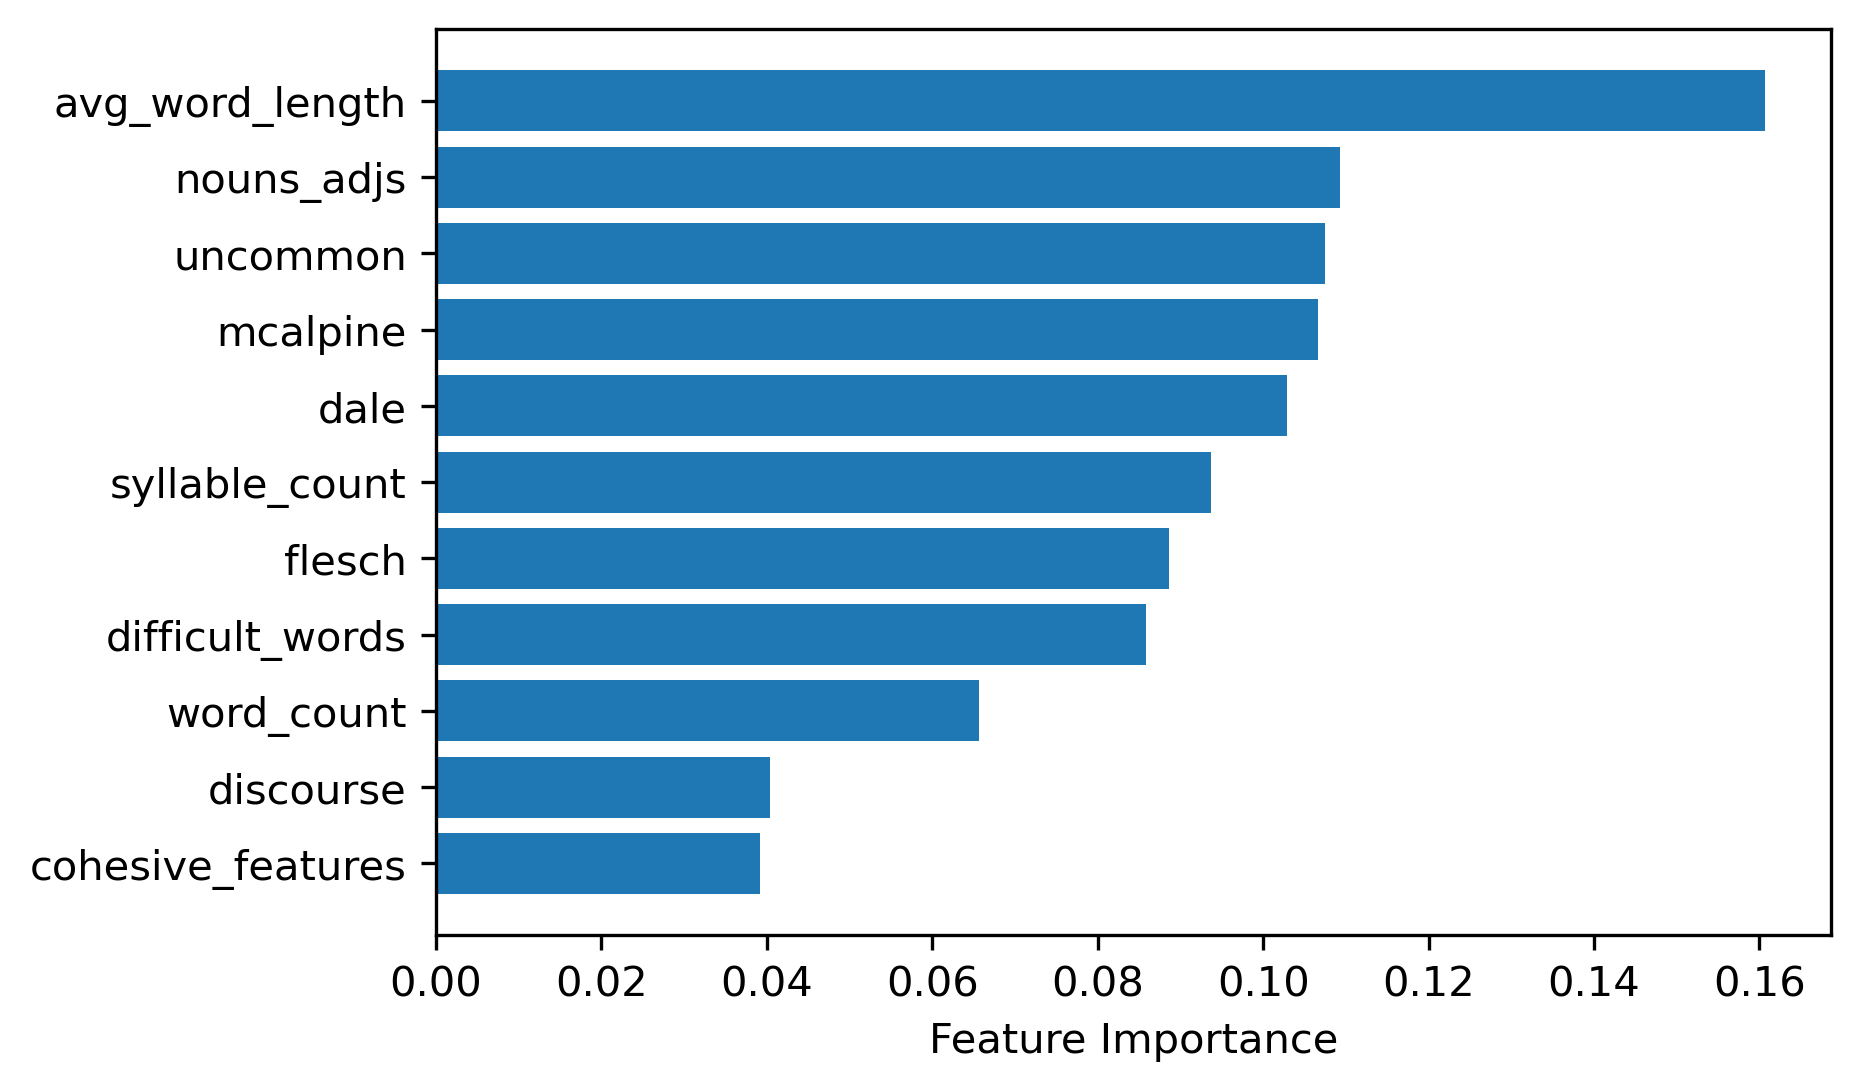

In [95]:
sort = rf.feature_importances_.argsort()
cols = df.loc[:,df.columns!='label']
plt.barh(cols.columns[sort], rf.feature_importances_[sort])
plt.xlabel("Feature Importance")
plt.savefig('figures/feature_importance_rf.jpg')

In [90]:
from sklearn.metrics import f1_score, accuracy_score

rf_acc = accuracy_score(y_test, rf_preds)*100
rf_f1 = f1_score(y_test, rf_preds)*100
rf_training_score = rf.score(X_train, y_train)

In [28]:
rf_acc, rf_f1, rf_training_score

(68.70989321374594, 70.34401784665963, 0.8796943812986627)

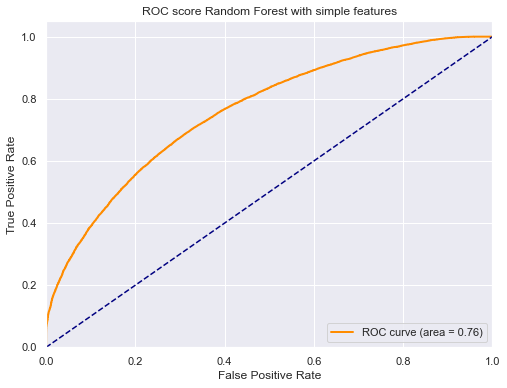

In [29]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

y_score = rf.predict_proba(X_test)
rf_fpr, rf_tpr, thresholds = roc_curve(y_test, y_score[:,1], pos_label=1)
area = auc(rf_fpr, rf_tpr)

plt.figure(figsize=(8,6))
lw = 2
plt.plot(rf_fpr, rf_tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC score Random Forest with simple features')
plt.legend(loc="lower right")
plt.savefig('figures/ROC_RF_simplefeatures.jpg')

In [25]:
pickle.dump(rf, open('models/random_forest.pkl', 'wb'))

# Gradient Boosted Decision Tree

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

glf = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 2, random_state = 42)
glf.fit(X_train.values, y_train.values)

print('(learning_rate=0.01, max_depth=2)')
print('Accuracy of GBDT classifier on training set: {:.2f}'
     .format(glf.score(X_train, y_train)))
print('Accuracy of GBDT classifier on test set: {:.2f}'
     .format(glf.score(X_test, y_test)))

(learning_rate=0.01, max_depth=2)
Accuracy of GBDT classifier on training set: 0.63
Accuracy of GBDT classifier on test set: 0.63


# GradientBoostingClassifier with GridSearchCV

In [35]:
#sample_train= X_train[np.random.choice(X_train.shape[0], 10000, replace=False), :]
sample = df.sample(frac=0.3, replace=False, random_state=42)
X= sample.loc[:, df.columns != 'label']
y= sample['label']

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split( X, y, test_size=0.2, random_state=42)

In [36]:
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
#creating Scoring parameter: 
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),'recall':make_scorer(recall_score)}

# A sample parameter

parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }
#passing the scoring function in the GridSearchCV
clf = GridSearchCV(GradientBoostingClassifier(), parameters,scoring=scoring,refit=False,cv=3, n_jobs=-1)

clf.fit(X_train_s,y_train_s)
#converting the clf.cv_results to dataframe
df=pd.DataFrame.from_dict(clf.cv_results_)
#here Possible inputs for cross validation is cv=2, there two split split0 and split1
df[['split0_test_accuracy','split1_test_accuracy','split0_test_precision',\
    'split1_test_precision','split0_test_recall','split1_test_recall']]

,split0_test_accuracy,split1_test_accuracy,split0_test_precision,split1_test_precision,split0_test_recall,split1_test_recall
0,0.558611,0.557916,0.540241,0.540134,0.943557,0.936618
1,0.592926,0.594277,0.565975,0.566501,0.889525,0.894404
2,0.595032,0.592852,0.566398,0.565184,0.902008,0.898323
3,0.598749,0.595515,0.570206,0.566867,0.888199,0.900314
4,0.597665,0.593967,0.568733,0.566300,0.896159,0.894223
...,...,...,...,...,...,...
48379,NaN,NaN,NaN,NaN,NaN,NaN
48380,NaN,NaN,NaN,NaN,NaN,NaN
48381,NaN,NaN,NaN,NaN,NaN,NaN
48382,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
#find the best parameter based on the accuracy_score
#taking the average of the accuracy_score
df['accuracy_score']=(df['split0_test_accuracy']+df['split1_test_accuracy'])/2

df.loc[df['accuracy_score'].idxmax()]['params']

{'criterion': 'friedman_mse',
 'learning_rate': 0.2,
 'loss': 'deviance',
 'max_depth': 8,
 'max_features': 'sqrt',
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.17272727272727273,
 'n_estimators': 10,
 'subsample': 0.85}

In [39]:
# prediction on the test set

clf =GradientBoostingClassifier(criterion='friedman_mse',
 learning_rate=0.2,
 loss='deviance',
 max_depth= 8,
 max_features='sqrt',
 min_samples_leaf= 0.1,
 min_samples_split= 0.17272727272727273,
 n_estimators=10,
 subsample=0.85)

clf.fit(X_train, y_train)
#correct_test = correct_data(test)
#testX = correct_test[predictor].values
result = clf.predict(X_test)

In [42]:
acc = accuracy_score(y_test, result)*100
acc

63.826466143058894

# XGBoost

In [56]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb

In [57]:
from sklearn.preprocessing import StandardScaler
sc= StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc= sc.transform(X_test)

In [58]:
xgb_cl = xgb.XGBClassifier()

In [59]:
xgb_cl.fit(X_train_sc, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [60]:
preds = xgb_cl.predict(X_test)
accuracy_score(y_test, preds)

0.6532791556205247

### Hyperparameter Tuning of XGBoost with GridSearchCV

In [45]:
param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

In the grid, I fixed subsample and colsample_bytree to recommended values to speed things up and prevent overfitting.
We will import GridSearchCV from sklearn.model_selection, instantiate and fit it to our preprocessed data:

In [54]:
# Init classifier
xgb_cl = xgb.XGBClassifier(objective="binary:logistic")

# Init Grid Search
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")

# Fit
_ = grid_cv.fit(X_train_sc, y_train)

In [47]:
grid_cv.best_score_

0.7055421581807623

In [61]:
final_cl = xgb.XGBClassifier(
    **grid_cv.best_params_,
    objective="binary:logistic"
)

In [62]:
from sklearn.metrics import roc_auc_score

_ = final_cl.fit(X_train_sc, y_train)

preds = final_cl.predict(X_test_sc)

accuracy_score(y_test, preds)

0.493198880107034

## SVM

A smaller value of C creates a small-margin hyperplane and a larger value of C creates a larger-margin hyperplane.
A lower value of Gamma will loosely fit the training dataset, whereas a higher value of gamma will exactly fit the training dataset, which causes over-fitting. In other words, you can say a low value of gamma considers only nearby points in calculating the separation line, while a high value of gamma considers all the data points in the calculation of the separation line.

In [ ]:
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import validation_curve

param_range = np.logspace(-7,-2,6)
clf = SVC(kernel = 'rbf', C = 1, random_state=42)
    
train_scores, test_scores = validation_curve(clf, X_train_scaled, y_train, 
                                                 param_name='gamma', 
                                                 param_range=param_range, cv=3, scoring="accuracy")

training_scores = np.mean(train_scores, axis=1)
testing_scores = np.mean(test_scores, axis=1)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
a=training_scores
b =testing_scores

# Remember to comment it out before submitting the notebook
# uncomment to plot

x = np.arange(-7, -1, 1)
plt.figure()
plt.plot(x, a, label="Avg Train Acc")
plt.plot(x, b, label="Avg Test Acc")
plt.xticks(x)
plt.xlabel('log scale: gamma parameter')
plt.ylabel("Accuracy")
plt.legend()
plt.show()